# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://opendata.vancouver.ca/explore/dataset/property-tax-report/table/?refine.report_year=2021). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2021.  

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd

df = pd.read_csv("property-tax-report_2021.csv")


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png" width="400">

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

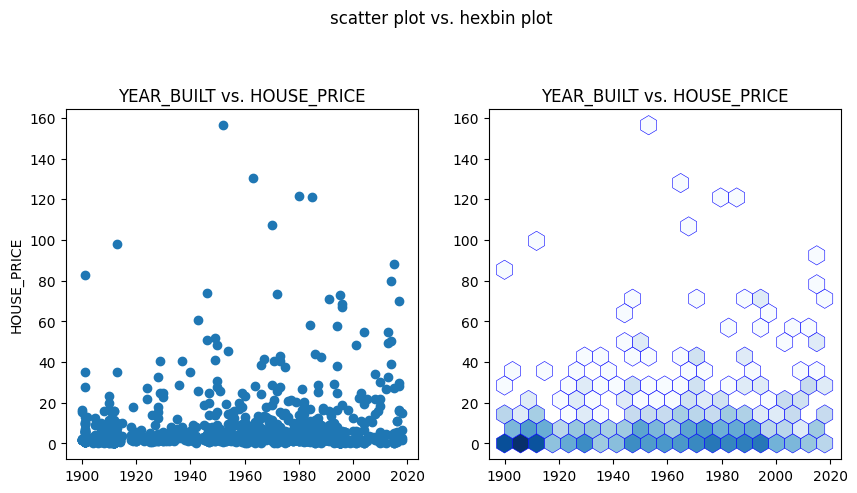

In [3]:
#<-- Write Your Code -->
import numpy as np
import matplotlib.pyplot as plt

df = df[(df['LEGAL_TYPE'] == 'LAND') & (df['YEAR_BUILT'] >= 1900) 
        & (df['PROPERTY_POSTAL_CODE'].str.contains('V6A', na=False))]

x = 'YEAR_BUILT'
y = 'HOUSE_PRICE'
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.scatter(df[x], df[y])
ax1.set_title(f'{x} vs. {y}')
ax2 = plt.subplot(222, sharey=ax1)
ax2.hexbin(df[x], df[y], gridsize=20, 
        mincnt=1, bins='log', linewidths=0.4, cmap='Blues', color='Blue')
ax2.set_title(f'{x} vs. {y}')

ax1.set_ylabel(y)
plt.suptitle('scatter plot vs. hexbin plot')
# need a color bar -0.25

plt.show()

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The highest HOUSE_PRICE of properties is 160 millions and build between 1940 and 1960.
2. From the hexbin plot, we could find that starting from 1990, there are more properties built with the prices less than 5 millions.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


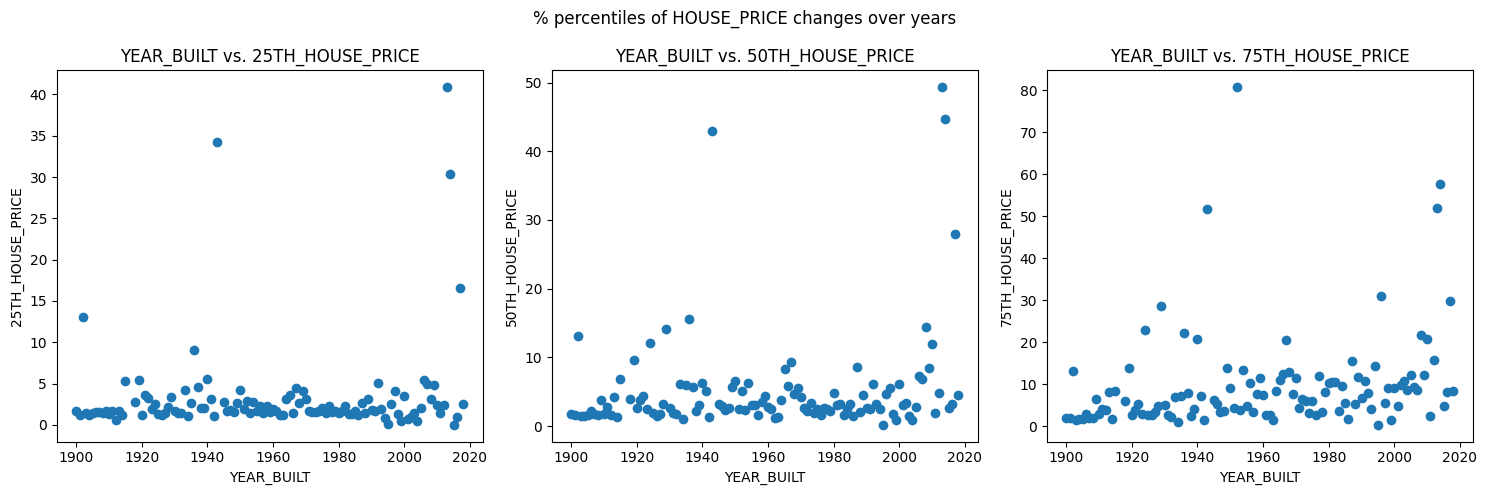

In [3]:
#<-- Write Your Code -->
import matplotlib.pyplot as plt

x = 'YEAR_BUILT'
y = 'HOUSE_PRICE'

df_group = df.groupby(x)
df_perc = df_group.describe()
df_perc = df_perc[y][['25%', '50%', '75%']].reset_index()
df_perc = df_perc.rename(columns={'25%': '25TH_HOUSE_PRICE', '50%': '50TH_HOUSE_PRICE', '75%': '75TH_HOUSE_PRICE'})


plt.figure(figsize=(15,5))
ax25 = plt.subplot(131)
ax25.scatter(df_perc[x], df_perc['25TH_HOUSE_PRICE'])
ax25.set(xlabel=x, ylabel='25TH_HOUSE_PRICE')
ax25.set_title(''+x+' vs. 25TH_HOUSE_PRICE')

ax50 = plt.subplot(132)
ax50.scatter(df_perc[x], df_perc['50TH_HOUSE_PRICE'])
ax50.set(xlabel=x, ylabel='50TH_HOUSE_PRICE')
ax50.set_title(''+x+' vs. 50TH_HOUSE_PRICE')

ax75 = plt.subplot(133)
ax75.scatter(df_perc[x], df_perc['75TH_HOUSE_PRICE'])
ax75.set(xlabel=x, ylabel='75TH_HOUSE_PRICE')
ax75.set_title(''+x+' vs. 75TH_HOUSE_PRICE')

plt.suptitle('% percentiles of HOUSE_PRICE changes over years')
plt.tight_layout()
plt.show()


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. In the 25TH_HOUSE_PRICE plot, we find most of the prices are concentrated within 10 millions. This might be due to the price control policy.
2. The major part of 75TH_HOUSE_PRICE is higher than that of 25TH_HOUSE_PRICE. And during 1940 and 1960, there are few properties with much higher values built in each plot as 'outliers'.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [4]:
def calc_pearson(df, x, y):
    #<-- Write Your Code -->   
    cov = ((df[x]-df[x].mean())*(df[y]-df[y].mean())).mean()
    std = (df[x].std()*df[y].std())
    return cov/std
    

def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    df = df.copy()
    df['rankX'] = df[x].rank()
    df['rankY'] = df[y].rank()
    covR = ((df['rankX']-df['rankX'].mean())*(df['rankY']-df['rankY'].mean())).mean()
    stdR = df['rankX'].std()*df['rankY'].std()
    return covR/stdR


Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [5]:
dfcor = df_perc[['YEAR_BUILT', '25TH_HOUSE_PRICE', '50TH_HOUSE_PRICE', '75TH_HOUSE_PRICE']]
print(dfcor.head(10))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1900.0          1.653000           1.72000           2.04615
1      1901.0          1.229325           1.59650           2.01200
2      1902.0         13.056000          13.05600          13.05600
3      1903.0          1.382600           1.47570           1.61030
4      1904.0          1.204300           1.40400           1.70100
5      1905.0          1.491350           1.61250           1.81925
6      1906.0          1.552750           2.15400           2.84135
7      1907.0          1.528800           1.76955           2.03275
8      1908.0          1.407475           1.58920           1.87325
9      1909.0          1.674250           3.84195           6.61775

25TH_HOUSE_PRICE	 pearson=0.138423	 spearman=0.046335
50TH_HOUSE_PRICE	 pearson=0.194428	 spearman=0.191103
75TH_HOUSE_PRICE	 pearson=0.238342	 spearman=0.400210


Please write down the **two** most interesting findings that you draw from the result.

 

**Findings**
1. For 50TH_HOUSE_PRICE, there is slightly a little difference between pearson and spearman correlations, which means there is few outliers amoung this price since the benefit of spearman is mitigating the effect of outliers.
2. All of these correlations are positive means the HOUSE_PRICE is positively related to YEAR_BUILT, and we could see this on the scatter plot before.

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [6]:
df_sample = pd.read_csv("property-tax-report_2021_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

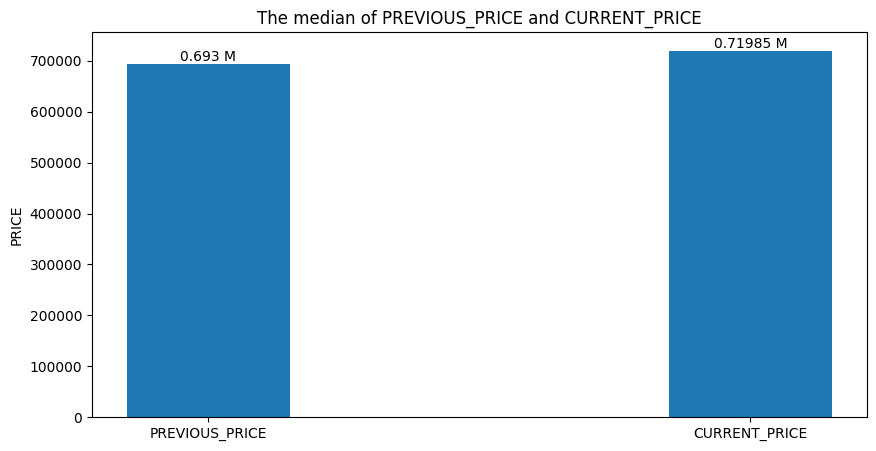

In [7]:
# --- Write your code below ---
import matplotlib.pyplot as plt

df_2 = df_sample[['PREVIOUS_PRICE','CURRENT_PRICE']]
df_median = df_2.median()

plt.figure(figsize=(10,5))
bar_plot = plt.bar(df_median.index, df_median.values, width=0.3)

for i, rect in enumerate(bar_plot):
    height = rect.get_height()
    values = str.format(f'{height/1000000} M')
    plt.annotate(values, (rect.get_x() + rect.get_width()/2, height),
        ha='center', va='bottom')

plt.ylabel('PRICE')
plt.title('The median of PREVIOUS_PRICE and CURRENT_PRICE')
plt.show()

### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, compute a 95%-confidence interval for each number, and add the confidence intervals to the above bar chart. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

Now, the median of PREVIOUS_PRICE is: 693000.0 
and the median of CURRENT_PRICE is: 719850.0
The 95%-confidence interval for PREVIOUS_PRICE is [664000.0, 720025.0].
The 95%-confidence interval for CURRENT_PRICE is [693700.0, 751700.0].


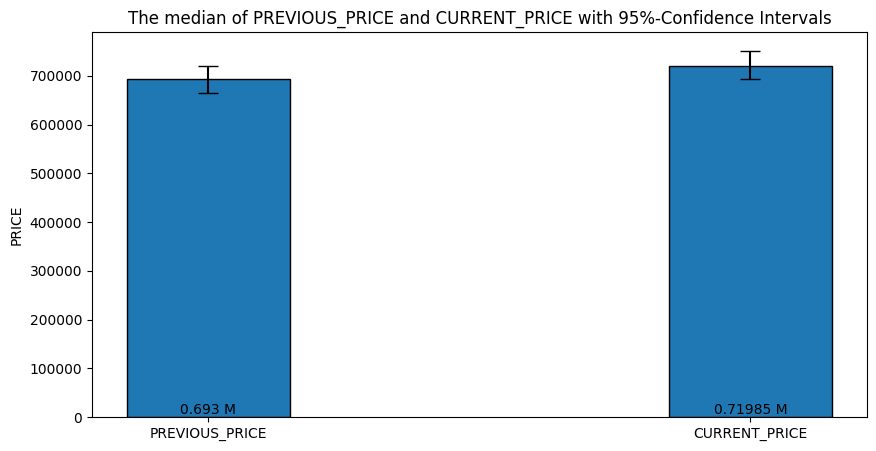

In [8]:
# --- Write your code below ---
import matplotlib.pyplot as plt

print('Now, the median of PREVIOUS_PRICE is:', df_median['PREVIOUS_PRICE'], 
    '\nand the median of CURRENT_PRICE is:', df_median['CURRENT_PRICE'])
    
def bootstrap(df, col, median, conf):
    sample_medians = []
    diffs = []
    df = df.dropna() 
    for i in range(1000):
        bootstrap_sample = df.sample(n=len(df), random_state = i, replace=True)
        boot_median = bootstrap_sample[col].median()
        sample_medians.append(boot_median)

    for i in sample_medians:
        diffs.append(i-median)
        
    #the length of differences
    df_diff = pd.DataFrame(diffs)
    
    diffs_sort = df_diff[col].sort_values()
    # get the 25th value and 975th value
    sigma_25 = diffs_sort.quantile((1-conf)/2)
    sigma_975 = diffs_sort.quantile(conf+(1-conf)/2)
    # get the lower bond and upper bond of the confidence interval
    start = median[col] - sigma_25
    end = median[col] - sigma_975

    print(f'The 95%-confidence interval for {col} is [{min(start,end)}, {max(start,end)}].')
    return [min(start,end), max(start,end)]
    
# add the confidence intervals to the above bar chart
conf_1 = bootstrap(df_2, 'PREVIOUS_PRICE', df_median, 0.95)

conf_2 = bootstrap(df_2, 'CURRENT_PRICE', df_median, 0.95)

# get the range of confidence intervals
range_1 = [abs(df_median['PREVIOUS_PRICE'] - conf_1[i]) for i in range(len(conf_1))]
range_2 = [abs(df_median['CURRENT_PRICE'] - conf_2[i]) for i in range(len(conf_2))]

plt.figure(figsize=(10,5))
bar_plot = plt.bar(df_median.index, df_median.values, width=0.3, yerr=[range_1, range_2], edgecolor='black', capsize=7)

for i, rect in enumerate(bar_plot):
    height = rect.get_height()
    values = str.format(f'{height/1000000} M')
    plt.annotate(values, (rect.get_x() + rect.get_width()/2, 0),
        ha='center', va='bottom')


plt.ylabel('PRICE')
plt.title('The median of PREVIOUS_PRICE and CURRENT_PRICE with 95%-Confidence Intervals')
plt.show()

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.